In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
from scipy import fft
import zarr
from matplotlib import pyplot, colors, cm
from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm, trange

mempool = cp.get_default_memory_pool()
pinned_mempool = cp.get_default_pinned_memory_pool()

def bytesize_string(nbytes):
    unit =          ['B',  'KiB' ,  'MiB' ,  'GiB' ,  'TiB' ,  'PiB' ,  'EiB' ,  'ZiB' ,  'YiB' ]
    size = np.array([ 1 , 1/2**10, 1/2**20, 1/2**30, 1/2**40, 1/2**50, 1/2**60, 1/2**70, 1/2**80]) * nbytes
    order_of_magnitude = np.argmax(size < 1.0) - 1
    return '{} {}'.format(size[order_of_magnitude], unit[order_of_magnitude])

def array_stats(a):
    print('{} × {} = {} | min: {}, max: {}, avg: {}'.format(a.shape, a.dtype, bytesize_string(a.nbytes), np.amin(a), np.amax(a), np.average(a)))

def display_image(values, color_map=None):
    values = values if color_map is None else cm.get_cmap(color_map)(values)
    display(Image.fromarray((np.flip(np.swapaxes(values, 0, 1), axis=0) * 255.0).astype(np.uint8)))
    
def save_image(name, values, color_map=None):
    values = values if color_map is None else cm.get_cmap(color_map)(values)
    Image.fromarray((np.flip(np.swapaxes(values, 0, 1), axis=0) * 255.0).astype(np.uint8)).save('figures/{}.png'.format(name))

In [2]:
# Focus range
n_f = 100
zeta_F = np.linspace(0.0, 5.0, num=n_f) / 1000

In [3]:
n_r = 1024

n_u = 20
n_v = 1080
chunk_v = 40
n_chunk = n_v//chunk_v

n_res = 4

n_a = np.arange(1, n_res+1, dtype=np.uint32) * 12
n_b = np.arange(1, n_res+1, dtype=np.uint32) * 140

# Light field groups.
chunk_group = 2
n_group = n_chunk - (chunk_group - 1)

In [4]:
scene = 'sponza'
index_res = 3

light_field = zarr.open('data/' + scene + '_sampled.zarr', mode='r')
interpolation = zarr.open('data/matrices/interpolation-{}x{}.zarr'.format(n_a[index_res], n_b[index_res]), mode='r')
naive = zarr.open('data/matrices/naive-{}x{}.zarr'.format(n_a[index_res], n_b[index_res]), mode='r')
projection = zarr.open('data/matrices/projection-{}x{}.zarr'.format(n_a[index_res], n_b[index_res]), mode='r')
autocorrelation = zarr.open('data/matrices/autocorrelation-{}x{}.zarr'.format(n_a[index_res], n_b[index_res]), mode='r')
simulation = zarr.open('data/matrices/simulation-{}x{}.zarr'.format(n_a[index_res], n_b[index_res]), mode='r')

n_ab = projection.shape[1]

print('Light field:')
display(light_field.info)

print('Iterpolation:')
display(interpolation.info)

print('Naive:')
display(naive.info)

print('Projection:')
display(projection.info)

print('Autocorrelation:')
display(autocorrelation.info)

print('Simulation:')
display(simulation.info)

Light field:


Type,zarr.core.Array
Data type,float32
Shape,"(20, 27, 40, 20, 27, 40, 3)"
Chunk shape,"(20, 1, 40, 20, 1, 40, 3)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,5598720000 (5.2G)
No. bytes stored,3225263092 (3.0G)
Storage ratio,1.7


Iterpolation:


Type,zarr.core.Array
Data type,float32
Shape,"(9056, 20, 27, 40)"
Chunk shape,"(9056, 20, 1, 40)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,782438400 (746.2M)
No. bytes stored,3387697 (3.2M)
Storage ratio,231.0


Naive:


Type,zarr.core.Array
Data type,float32
Shape,"(9056, 20, 27, 40)"
Chunk shape,"(9056, 20, 1, 40)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,782438400 (746.2M)
No. bytes stored,3192105 (3.0M)
Storage ratio,245.1


Projection:


Type,zarr.core.Array
Data type,float32
Shape,"(100, 9056, 20, 27, 40)"
Chunk shape,"(1, 9056, 20, 1, 40)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,78243840000 (72.9G)
No. bytes stored,653101405 (622.8M)
Storage ratio,119.8


Autocorrelation:


Type,zarr.core.Array
Data type,float32
Shape,"(100, 9056, 9056)"
Chunk shape,"(1, 9056, 9056)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,32804454400 (30.6G)
No. bytes stored,514996456 (491.1M)
Storage ratio,63.7


Simulation:


Type,zarr.core.Array
Data type,float32
Shape,"(100, 1024, 9056)"
Chunk shape,"(1, 1024, 9056)"
Order,C
Read-only,True
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,3709337600 (3.5G)
No. bytes stored,56492264 (53.9M)
Storage ratio,65.7


In [5]:
%%time

transform = interpolation

# Assign each element to a group.
chunk_incidence_per_element = np.any(transform, axis=(1, 3))
element_assignment_per_group = np.minimum(np.argmax(chunk_incidence_per_element, axis=1), n_group-1).reshape(1, n_ab) == np.arange(n_group).reshape(n_group, 1)
element_indices_per_group = [np.nonzero(element_assignment)[0] for element_assignment in element_assignment_per_group]

# Load the light field and the projection matrix into the GPU
light_field_GPU = cp.array(light_field[:])
transform_GPU = cp.array(transform[:])

# Interpolation coefficients to be computed
coefficients_GPU = cp.zeros((n_ab, n_ab, 3), dtype=cp.float32)

# GPU events for timing
start_event = cp.cuda.Event()
end_event = cp.cuda.Event()

# Record start event
start_event.record()

for idx_group in range(n_group):
    slice_x = slice(idx_group, idx_group + chunk_group)
    for idy_group in range(n_group):
        slice_y = slice(idy_group, idy_group + chunk_group)

        # Select sample values for this group.
        sample_values_GPU = light_field_GPU[:, slice_x, :, :, slice_y, :].reshape(n_u * chunk_group * chunk_v, n_u * chunk_group * chunk_v, 3)

        # Display elements assigned to this group.
        idx_element = element_indices_per_group[idx_group]
        idy_element = element_indices_per_group[idy_group]

        # Compute projection coefficients.
        lm_x_GPU = transform_GPU[idx_element][:, :, slice_x, :].reshape(-1, n_u * chunk_group * chunk_v)
        lm_y_GPU = transform_GPU[idy_element][:, :, slice_y, :].reshape(-1, n_u * chunk_group * chunk_v)
        coefficients_GPU[np.ix_(idx_element, idy_element)] = cp.einsum('hx,vy,xyc->hvc', lm_x_GPU, lm_y_GPU, sample_values_GPU)

# Record end event
end_event.record()

# Synchronize with end event and measure elapsed time
end_event.synchronize()
transform_time = cp.cuda.get_elapsed_time(start_event, end_event)

zarr.open('data/{}/times-interpolation.zarr'.format(scene), mode='a', shape=(n_res), chunks=(1), dtype=np.float32)[index_res] = transform_time

print('Scene: {}, Resolution: {}x{}, Interpolation time: {} ms'.format(scene, n_a[index_res], n_b[index_res], transform_time))

# Free GPU memory
del sample_values_GPU
del lm_x_GPU
del lm_y_GPU
del light_field_GPU
del transform_GPU
mempool.free_all_blocks()

Scene: sponza, Resolution: 48x560, Interpolation time: 3021.781005859375 ms
Wall time: 13.5 s


Interpolation:


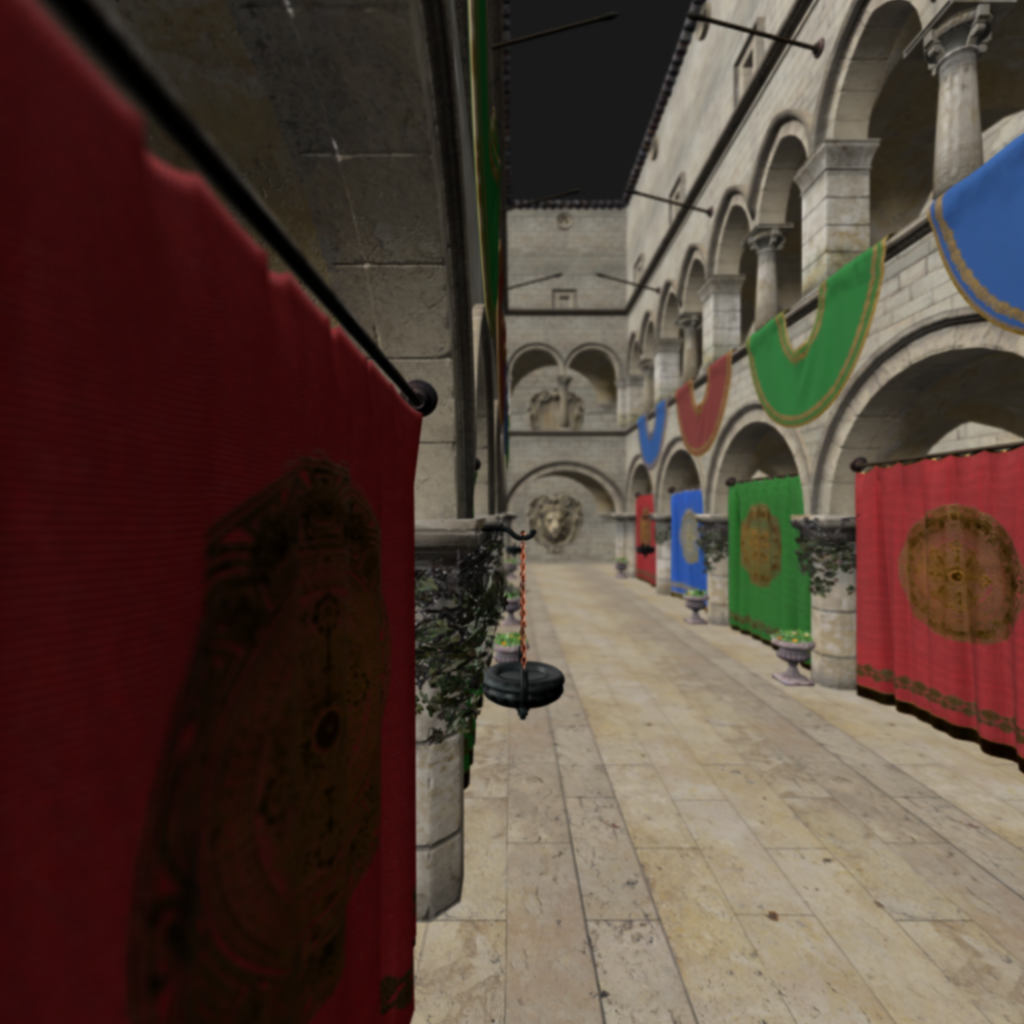

In [6]:
simulation_GPU = cp.array(simulation[20])

retinal_image = cp.tensordot(simulation_GPU, cp.tensordot(simulation_GPU, coefficients_GPU, axes=(1, 1)), axes=(1, 1)).get()

# Free GPU memory
del simulation_GPU
del coefficients_GPU
mempool.free_all_blocks()

print('Interpolation:')
display_image(retinal_image)

In [7]:
%%time

transform = naive

# Assign each element to a group.
chunk_incidence_per_element = np.any(transform, axis=(1, 3))
element_assignment_per_group = np.minimum(np.argmax(chunk_incidence_per_element, axis=1), n_group-1).reshape(1, n_ab) == np.arange(n_group).reshape(n_group, 1)
element_indices_per_group = [np.nonzero(element_assignment)[0] for element_assignment in element_assignment_per_group]

# Load the light field and the projection matrix into the GPU
light_field_GPU = cp.array(light_field[:])
transform_GPU = cp.array(transform[:])

# Interpolation coefficients to be computed
coefficients_GPU = cp.zeros((n_ab, n_ab, 3), dtype=cp.float32)

# GPU events for timing
start_event = cp.cuda.Event()
end_event = cp.cuda.Event()

# Record start event
start_event.record()

for idx_group in range(n_group):
    slice_x = slice(idx_group, idx_group + chunk_group)
    for idy_group in range(n_group):
        slice_y = slice(idy_group, idy_group + chunk_group)

        # Select sample values for this group.
        sample_values_GPU = light_field_GPU[:, slice_x, :, :, slice_y, :].reshape(n_u * chunk_group * chunk_v, n_u * chunk_group * chunk_v, 3)

        # Display elements assigned to this group.
        idx_element = element_indices_per_group[idx_group]
        idy_element = element_indices_per_group[idy_group]

        # Compute projection coefficients.
        lm_x_GPU = transform_GPU[idx_element][:, :, slice_x, :].reshape(-1, n_u * chunk_group * chunk_v)
        lm_y_GPU = transform_GPU[idy_element][:, :, slice_y, :].reshape(-1, n_u * chunk_group * chunk_v)
        coefficients_GPU[np.ix_(idx_element, idy_element)] = cp.einsum('hx,vy,xyc->hvc', lm_x_GPU, lm_y_GPU, sample_values_GPU)

# Record end event
end_event.record()

# Synchronize with end event and measure elapsed time
end_event.synchronize()
transform_time = cp.cuda.get_elapsed_time(start_event, end_event)

zarr.open('data/{}/times-naive.zarr'.format(scene), mode='a', shape=(n_res), chunks=(1), dtype=np.float32)[index_res] = transform_time

print('Scene: {}, Resolution: {}x{}, Naive time: {} ms'.format(scene, n_a[index_res], n_b[index_res], transform_time))

# Free GPU memory
del sample_values_GPU
del lm_x_GPU
del lm_y_GPU
del light_field_GPU
del transform_GPU
mempool.free_all_blocks()

Scene: sponza, Resolution: 48x560, Naive time: 2798.201904296875 ms
Wall time: 11.3 s


Naive:


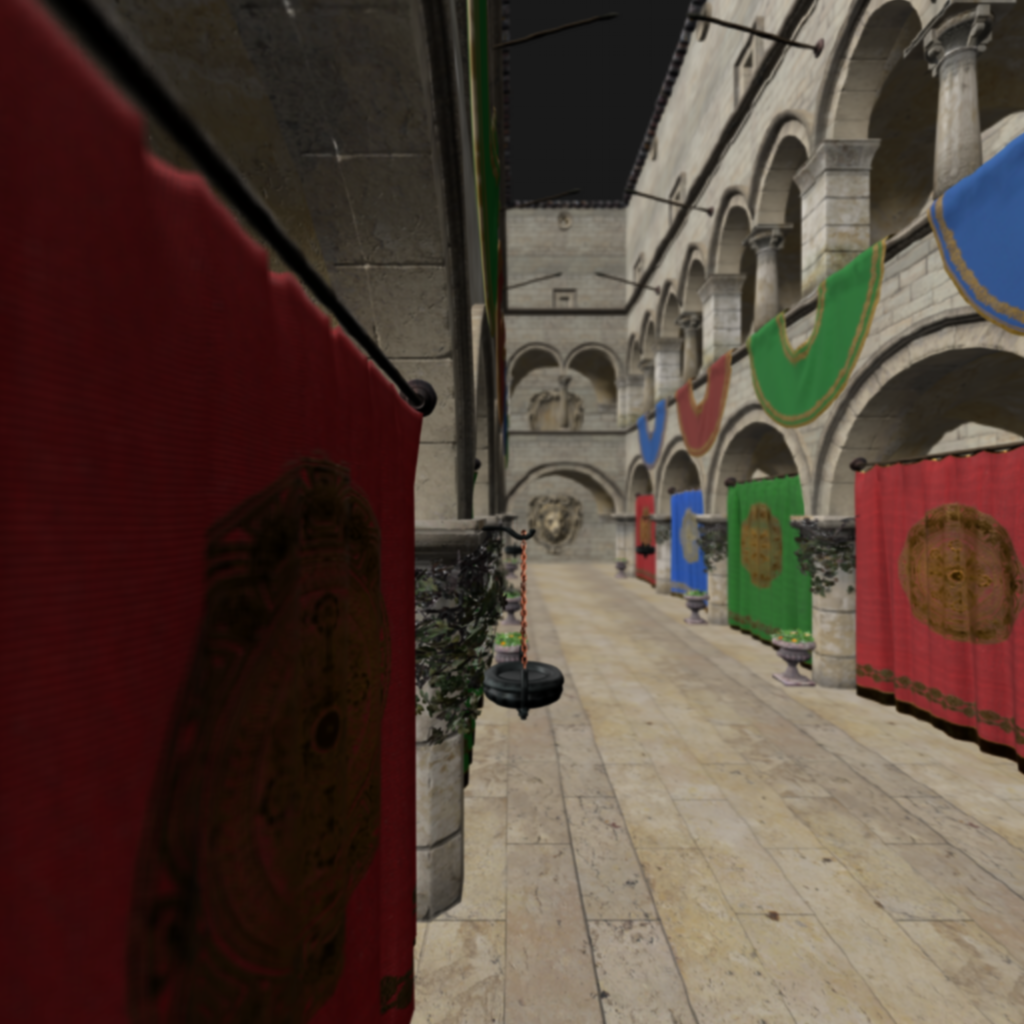

In [8]:
simulation_GPU = cp.array(simulation[20])

retinal_image = cp.tensordot(simulation_GPU, cp.tensordot(simulation_GPU, coefficients_GPU, axes=(1, 1)), axes=(1, 1)).get()

# Free GPU memory
del simulation_GPU
del coefficients_GPU
mempool.free_all_blocks()

print('Naive:')
display_image(retinal_image)

In [9]:
%%time

continuous_projection = np.zeros((n_ab, n_u, n_chunk, chunk_v), dtype=np.float32)
continuous_autocorrelation = np.zeros((n_ab, n_ab), dtype=np.float32)

with tqdm(total=n_f) as pbar:
    for index_f in range(n_f):
        continuous_projection += projection[index_f] / n_f
        continuous_autocorrelation += autocorrelation[index_f] / n_f
        pbar.update()

  0%|          | 0/100 [00:00<?, ?it/s]

Wall time: 1min 51s


In [10]:
%%time

n_iter = 50

rng = cp.random.default_rng()

# Assign each element to a group.
chunk_incidence_per_element = np.any(continuous_projection, axis=(1, 3))
element_assignment_per_group = np.minimum(np.argmax(chunk_incidence_per_element, axis=1), n_group-1).reshape(1, n_ab) == np.arange(n_group).reshape(n_group, 1)
element_indices_per_group = [np.nonzero(element_assignment)[0] for element_assignment in element_assignment_per_group]

# Load the light field and the projection matrix into the GPU
light_field_GPU = cp.array(light_field[:])
projection_GPU = cp.array(continuous_projection[:])

# Projection coefficients to be computed
projection_coef_GPU = cp.zeros((n_ab, n_ab, 3), dtype=cp.float32)

# GPU events for timing
start_event = cp.cuda.Event()
end_event = cp.cuda.Event()

# Record start event
start_event.record()

for idx_group in range(n_group):
    slice_x = slice(idx_group, idx_group + chunk_group)
    for idy_group in range(n_group):
        slice_y = slice(idy_group, idy_group + chunk_group)

        # Select sample values for this group.
        sample_values_GPU = light_field_GPU[:, slice_x, :, :, slice_y, :].reshape(n_u * chunk_group * chunk_v, n_u * chunk_group * chunk_v, 3)

        # Display elements assigned to this group.
        idx_element = element_indices_per_group[idx_group]
        idy_element = element_indices_per_group[idy_group]

        # Compute projection coefficients.
        lm_x_GPU = projection_GPU[idx_element][:, :, slice_x, :].reshape(-1, n_u * chunk_group * chunk_v)
        lm_y_GPU = projection_GPU[idy_element][:, :, slice_y, :].reshape(-1, n_u * chunk_group * chunk_v)
        projection_coef_GPU[np.ix_(idx_element, idy_element)] = cp.einsum('hx,vy,xyc->hvc', lm_x_GPU, lm_y_GPU, sample_values_GPU)

# Record end event
end_event.record()

# Synchronize with end event and measure elapsed time
end_event.synchronize()
projection_time = cp.cuda.get_elapsed_time(start_event, end_event)

zarr.open('data/{}/times-projection-continuous.zarr'.format(scene), mode='a', shape=(n_res), chunks=(1), dtype=np.float32)[index_res] = projection_time

print('Scene: {}, Resolution: {}x{}, Projection time: {} ms'.format(scene, n_a[index_res], n_b[index_res], projection_time))

# Free GPU memory
del sample_values_GPU
del lm_x_GPU
del lm_y_GPU
del light_field_GPU
del projection_GPU
mempool.free_all_blocks()

autocorrelation_GPU = cp.array(continuous_autocorrelation[:])

# GPU events for timing
start_event = cp.cuda.Event()
iteration_events = [cp.cuda.Event() for index_iter in range(n_iter)]

# Record start event
start_event.record()

coefficients_GPU = 1.0 - rng.random((n_ab, n_ab, 3), dtype=cp.float32)
# For each multiplicative rule iteration...
for index_iter in range(n_iter):
    # Apply the autocorrelation linear map on current coefficients.
    temp = cp.tensordot(autocorrelation_GPU, cp.tensordot(autocorrelation_GPU, coefficients_GPU, axes=(1, 1)), axes=(1, 1))
    # Divide the projected coefficients by the autocorrelated coefficients.
    temp = cp.add(temp, cp.finfo(cp.float32).eps, out=temp)
    temp = cp.divide(projection_coef_GPU, temp, out=temp)
    # Update current coefficients with the multiplicative rule.
    coefficients_GPU = cp.multiply(coefficients_GPU, temp, out=coefficients_GPU)
    # Clip coefficients to interval [0, 1].
    coefficients_GPU = cp.clip(coefficients_GPU, 0.0, 1.0, out=coefficients_GPU)
    # Record iteration event
    iteration_events[index_iter].record()

# Synchronize with last iteration event and measure elapsed times
iteration_events[-1].synchronize()
iteration_times = [cp.cuda.get_elapsed_time(start_event, iteration_events[index_iter]) for index_iter in range(n_iter)]

zarr.open('data/{}/times-iteration-continuous.zarr'.format(scene), mode='a', shape=(n_res, n_iter), chunks=(1, n_iter), dtype=np.float32)[index_res, :] = iteration_times

print('Scene: {}, Resolution: {}x{}, Iterations time: {} ms'.format(scene, n_a[index_res], n_b[index_res], iteration_times[-1]))

# Free GPU memory
del projection_coef_GPU
del autocorrelation_GPU
del temp
mempool.free_all_blocks()

Scene: sponza, Resolution: 48x560, Projection time: 2603.979736328125 ms
Scene: sponza, Resolution: 48x560, Iterations time: 99489.03125 ms
Wall time: 1min 50s


Continuous:


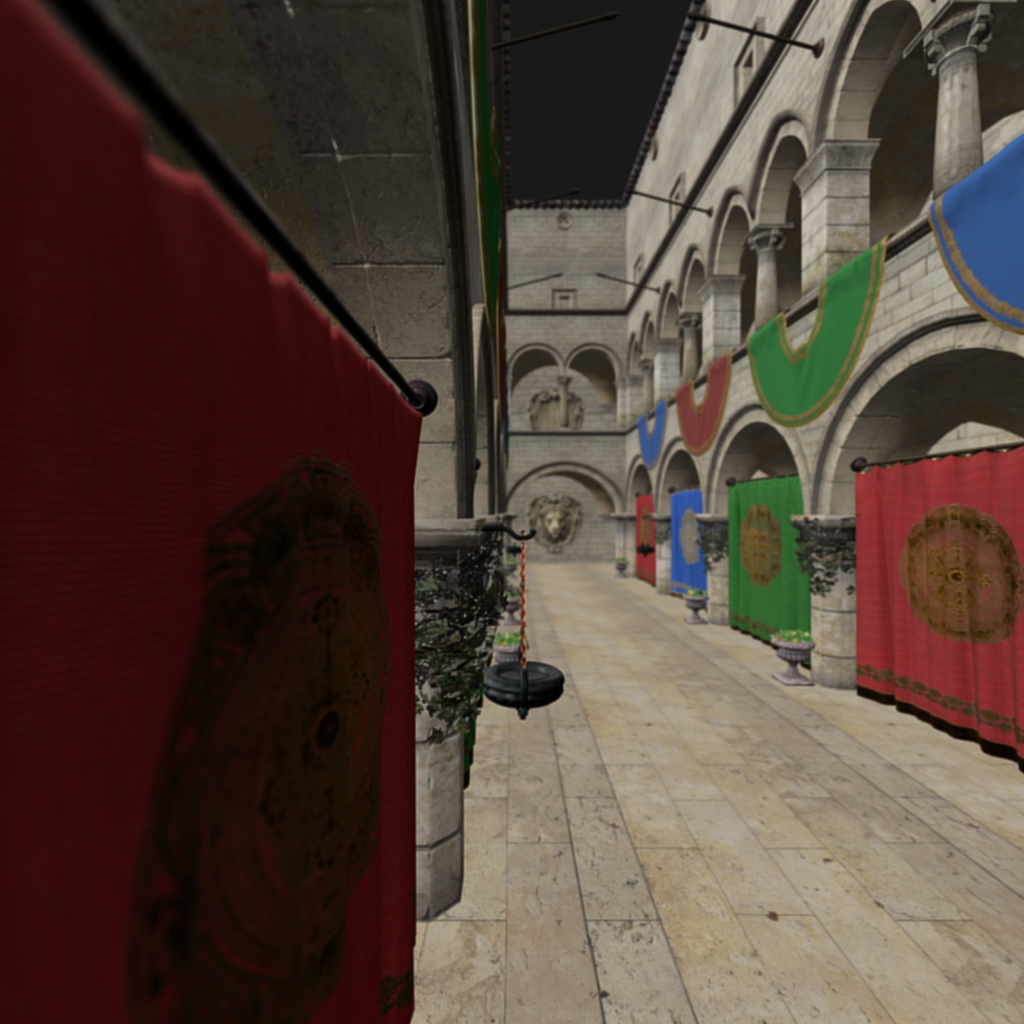

In [11]:
simulation_GPU = cp.array(simulation[20])

retinal_image = cp.tensordot(simulation_GPU, cp.tensordot(simulation_GPU, coefficients_GPU, axes=(1, 1)), axes=(1, 1)).get()

# Free GPU memory
del simulation_GPU
del coefficients_GPU
mempool.free_all_blocks()

print('Continuous:')
display_image(retinal_image)